<a href="https://colab.research.google.com/github/debasismpt125/Limit-Analysis/blob/master/PLAXIS3D_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Created on Mon Feb 12 15:18:36 2024

author: Henry Gunawan


## Environment

In [ ]:
#General Library
import numpy as np
from math import pi
import pandas as pd
from PIL import Image
from IPython.display import display
import math
import os
import sys
import shutil
import subprocess
import matplotlib.pyplot as plt

#Library for email
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

#Library for Plaxis scripting
from plxscripting.easy import*

#Path
plaxis_script_lib_path=r'C:\ProgramData\Seequent\PLAXIS Python Distribution V2'
working_folder = r'C:\Users\Henry\Delft University of Technology\Master Thesis - General\thesis_start\plaxis3d'
simulation_name = r'\script_test_model'
results_path = working_folder + simulation_name + '.p3d'
plaxis_python_path=r'C:\ProgramData\Seequent\PLAXIS Python Distribution V2\python\Lib\site-packages'
sys.path.insert(0,os.path.join(plaxis_script_lib_path,plaxis_python_path))

#Server
in_port  = 10000
out_port = 10001
address = 'localhost'
pw = '*****' #from plaxis scripting

s_i, g_i = new_server('localhost', port=in_port, password=pw )
s_o, g_o = new_server('localhost', port=out_port, password=pw )

## Define Soil and Scenarios

In [ ]:
#There are 2 soil_type to choose, i.e. "sanisandms" and "linearelastic"
soil_type = "linearelastic"

#There are 3 scenarios to choose, 1 is design as pile group with offset 0.1,
#2 is combined piled raft, 3 is disconnected piled raft
scenario_type =[1,2,3]
scenario_name ={1:"Pile Group", 2:"Piled Raft", 3:"Disconnected Piled Raft"}
scenario = 1

#Load Step
load_steps = 8
pile_number = 4
pile_X_coord = [-4.5,-1.5,1.5,4.5]

#Set Load
#load is load_steps+1 (equilibrium step where 0)
#1 to 4 is the vertical load, 5 to 8 is the horizontal and moment load (earthquake)
horizontal_load = [0,   0,   0,   0,   0, 1e3,   2e3, 3e3, 4e3]
vertical_load   = [0, 5e3, 1e4, 2e4, 3e4, 3e4,   3e4, 3e4, 3e4]
moment          = [0,   0,   0,   0,   0, 1e4, 2.5e4, 4e4, 5e4]

#list of soil to be used in borehole
soil_list = list()

#general properties
xmax = 25
xmin = -25
ymax = 20
ymin = 0
soil_depth = 25

#Meshing Detail
detail_zone_coarseness_factor = 0.5
#Output processing
raft_data = {}
nodes_data = {}
piles_data = {}

#Load Dataframe
df_load = pd.DataFrame({'vertical_load [kN]': vertical_load, 'horizontal_load [kN]': horizontal_load, 'moment [kNm]': moment})
df_load

,vertical_load [kN],horizontal_load [kN],moment [kNm]
0,0.0,0.0,0.0
1,5000.0,0.0,0.0
2,10000.0,0.0,0.0
3,20000.0,0.0,0.0
4,30000.0,0.0,0.0
5,30000.0,1000.0,10000.0
6,30000.0,2000.0,25000.0
7,30000.0,3000.0,40000.0
8,30000.0,4000.0,50000.0


## Setting Up Push Notification to E-Mail

In [ ]:
#Function to send email
def send_email():
    # email credentials
    from_email = "a@gmail.com"
    password   = "****"  #For this check signin with app password in google
    to_email   = "a@gmail.com"

    # Get message info
    message_info = get_message_info()
    subject = message_info["Subject"]
    body = message_info["Body"]

    # Create a multipart message
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject

    # Add body to email
    msg.attach(MIMEText(body, 'plain'))

    # Create server object with SSL option
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)

    # Perform operations via server
    try:
        server.login(from_email, password)
        text = msg.as_string()
        server.sendmail(from_email, to_email, text)
        print("Email sent successfully")
    except Exception as e:
        print(f"Failed to send email: {e}")
    finally:
        server.quit()

In [ ]:
#Function to get the phase overview
def gather_phase_overview():
    results = []
    allpassed = True
    for phase in g_i.Phases[:]:
        msg = "not calculated"
        if not phase.ShouldCalculate:
            if phase.CalculationResult == phase.CalculationResult.ok:
                msg = "OK" # may be extended for more details
            else:
                msg = "Failed: error {0}".format(phase.LogInfo)
                allpassed = False
        results.append("{0}: {1}".format( phase.Name, msg))
    return allpassed, results

#Function to get the email subject and body
def get_message_info():
    message = {"Subject": "", "Body": ""}
    allpassed, results = gather_phase_overview()
    if allpassed == True:
        message["Subject"] = f"PLAXIS Calculation Scenario {scenario} OK"
    else:
        message["Subject"] = "Calculation failed"
    body = ["Summary for PLAXIS calculation"]
    body.append("Title: {0}".format(g_i.Project.Title))
    body.append("File: {0}".format(g_i.Project.Filename))
    body.append('')
    body.append('Phase results:')
    for result in results:
        body.append('- {0}'.format(result))
    message["Body"] = "\n".join(body)
    return message

## New File and Model

In [ ]:
def new_file():
    #Create New File
    s_i.new()

    # Set model and elements properties
    g_i.setproperties("Title", "Piled_Raft", #File Name
                      "UnitForce", "kN",
                      "UnitLength","m")

new_file()

### Set Material Color

In [ ]:
def get_RGB_number(R, G, B):
    # get colour number from RGB using BIT LEFT SHIFT
    iB = B<<16 # left shift 16 bits for Blue
    iG = G<<8  # left shift  8 bits for Green
    iR = R     # left shift  0 bits for Red
    return iB + iG + iR

def setMaterialColourRGB(material, R, G, B):
    material.Colour = get_RGB_number(R, G, B)

# Input

## General Properties

In [ ]:
def general_properties():
    #Contour
    g_i.SoilContour.initializerectangular(xmin, ymin, xmax, ymax)
    colors_soil = np.random.randint(low=1e6, high=9e6, size=10)

general_properties()

## Sanisand-ms Soil Properties

### Soil Properties

In [ ]:
#General
##General Properties
sanisandms_soil_name = "sanisandms"
sanisandms_SoilModel = 100 #User-defined
sanisandms_DrainageType = 0 #Drained
sanisandms_soil_color = get_RGB_number(255, 245, 190)
## Unit Weights
sanisandms_gamma_unsat = 15
sanisandms_gamma_sat   = 17
## Void Ratio
sanisandms_e_max = 1.07
sanisandms_e_min = 0.64
sanisandms_RD    = 0.8
sanisandms_e0    = sanisandms_e_max - sanisandms_RD*(sanisandms_e_max - sanisandms_e_min)


#Mechanical
##User-defined parameters for SANISAND-MS. Created with Gebasand Parameter
sanisandms_G0           = 400      # G0        Shear modulus constant
sanisandms_nu           = 0.05      # nu        Poisson's ratio
sanisandms_M_c          = 1.25      # M_c       Slope of CSL in q:p pl
sanisandms_c            = 0.702      # c         M_e/M_c
sanisandms_lambda_c     = 0.0015      # lambda_c  CSL parameter (e:p pl
sanisandms_e_0          = 0.935      # e_0       Void ration on CSL at
sanisandms_xi           = 0.7         # xi        CSL parameter (e:p pla
sanisandms_m            = 0.1         # m         m_0, opening of yield s
sanisandms_h_0          = 8.64        # h0        Plastic modulus const
sanisandms_c_h          = 1.09        # c_h       Plastic modulus constan
sanisandms_n_b          = 0.96        # n_b       Plastic modulus const
sanisandms_A_0          = 1.104       # A0        Dilatancy constant
sanisandms_n_d          = 0.75        # n_d       Dilatancy constant
sanisandms_mu_0         = 500         # mu_0      Memory-surface const
sanisandms_zeta         = 0.0001      # zeta      Memory surface shrink
sanisandms_beta         = 0           # beta      Dilatancy constant
sanisandms_e_ini        = sanisandms_e0      # e_in
sanisandms_e_max        = sanisandms_e_max      # e_max
sanisandms_e_min        = sanisandms_e_min      # e_min
sanisandms_M_c_bmax     = 1.92
sanisandms_El_Scheme    = 0.0001


#Groundwater
##Model
sanisandms_GroundwaterClassificationType = 0 #Standard
sanisandms_GroundwaterSoilClassStandard  = 1 #Medium
##Flow Parameters
sanisandms_GwUseDefaults = True #Use Default Permeabilities


#Interfaces
## Stiffness
sanisandms_InterfaceStiffnessDetermination =  2 #From Eoed
sanisandms_EoedInter = 30.0E3
sanisandms_UDPowerInter =  0.5
sanisandms_UDPRefInter =   0.5
##Strength
sanisandms_CInter = 5
sanisandms_PhiInter= 20.0
sanisandms_PsiInter = 5.0
sanisandms_GapClosure = True #Check the Gap Closure
##Groundwater
sanisandms_CrossPermeability = 0 #Impermeable


#Initial
sanisandms_K0Determination = 0 #Automatic

### Create Soil Material

In [ ]:
def create_material_sanisandms():
    soil_material = g_i.soilmat()
    g_i.sps(g_i.SoilMat_1,
            # GENERAL
            ## Material Set
            "Identification", sanisandms_soil_name,
            "SoilModel",    sanisandms_SoilModel,
            "DllFile",  "sanisandms64.dll",     # Dynamic link library from drop-down menu in Plaxis
            "ModelInDll",    "SANISANDMS",
            "DrainageType",    sanisandms_DrainageType,
            "Colour",       sanisandms_soil_color,
            ## Unit Weights
            "gammaUnsat",   sanisandms_gamma_unsat,
            "gammaSat",     sanisandms_gamma_sat,
            ## Void Ratio
            "eInit",  sanisandms_e0,


            # Mechanical
            ## User-defined parameters
            "User1",  sanisandms_G0,
            "User2",  sanisandms_nu,
            "User3",  sanisandms_M_c,
            "User4",  sanisandms_c,
            "User5",  sanisandms_lambda_c,
            "User6",  sanisandms_e_0,
            "User7",  sanisandms_xi,
            "User8",  sanisandms_m,
            "User9",  sanisandms_h_0,
            "User10", sanisandms_c_h,
            "User11", sanisandms_n_b,
            "User12", sanisandms_A_0,
            "User13", sanisandms_n_d,
            "User14", sanisandms_mu_0,
            "User15", sanisandms_zeta,
            "User16", sanisandms_beta,
            "User17", sanisandms_e_ini,
            "User18", sanisandms_e_max,
            "User19", sanisandms_e_min,
            "User20", sanisandms_M_c_bmax,
            "User21", sanisandms_El_Scheme,


            # Groundwater
            ## Model
            "GroundwaterClassificationType", sanisandms_GroundwaterClassificationType,
            "GroundwaterSoilClassStandard", sanisandms_GroundwaterSoilClassStandard,
            ## Flow Parameters
            "GwUseDefaults", sanisandms_GwUseDefaults,


            # Interfaces
            ## Stiffness
            "InterfaceStiffnessDetermination", sanisandms_InterfaceStiffnessDetermination,
            "EoedInter", sanisandms_EoedInter,
            "UDPowerInter", sanisandms_UDPowerInter,
            "UDPRefInter", sanisandms_UDPRefInter,
            ## Strength
            "CInter", sanisandms_CInter,
            "PhiInter", sanisandms_PhiInter,
            "PsiInter", sanisandms_PsiInter,
            "GapClosure", sanisandms_GapClosure,
            ## Groundwater
            "CrossPermeability", sanisandms_CrossPermeability,


            # Initial
            "K0Determination", sanisandms_K0Determination
           )

    #Append Material to soil_list for borehole
    soil_list.append(soil_material)

create_material_sanisandms()

## Linear Elastic Soil Properties

### Soil Properties

In [ ]:
#General
##General Properties
linearelastic_soil_name = "linear_elastic"
linearelastic_SoilModel = 1 #Linear Elastic
linearelastic_DrainageType = 0 #Drained
linearelastic_soil_color = get_RGB_number(230, 210, 160)
## Unit Weights
linearelastic_gamma_unsat = 15
linearelastic_gamma_sat   = 17
## Void Ratio
linearelastic_e_max = 1.07
linearelastic_e_min = 0.64
linearelastic_RD    = 0.8
linearelastic_e0    = linearelastic_e_max - linearelastic_RD * (linearelastic_e_max - linearelastic_e_min)


#Mechanical
linearelastic_ERef = 50000 #kN/m2
linearelastic_nu   = 0.2


#Interface
linearelastic_InterfaceStiffnessDetermination = 0 #Derived
linearelastic_InterfaceStrengthDetermination  = 1 #Manual
linearelastic_Rinter = 0.67
linearelastic_GapClosure = True

### Create Soil Material

In [ ]:
def create_material_linearelastic():
    soil_material = g_i.soilmat()
    g_i.sps(g_i.SoilMat_1,
            # GENERAL
            ## Material Set
            "Identification", linearelastic_soil_name,
            "SoilModel",    linearelastic_SoilModel,
            "DrainageType",    linearelastic_DrainageType,
            "Colour",       linearelastic_soil_color,
            ## Unit Weights
            "gammaUnsat",   linearelastic_gamma_unsat,
            "gammaSat",     linearelastic_gamma_sat,
            ## Void Ratio
            "eInit",  linearelastic_e0,


            # Mechanical
            ## Stiffness
            "ERef",  linearelastic_ERef,
            "nu",  linearelastic_nu,


            # Interfaces
            ## Stiffness
            "InterfaceStiffnessDetermination", linearelastic_InterfaceStiffnessDetermination,
            "InterfaceStrengthDetermination", linearelastic_InterfaceStrengthDetermination,
            "Rinter", linearelastic_Rinter,
            "GapClosure", linearelastic_GapClosure,
           )

    #Append Material to soil_list for borehole
    soil_list.append(soil_material)

create_material_linearelastic()

## Create Borehole

### General

In [ ]:
def create_borehole():
    # x,y = x,y-coordinate of the borehole
    borehole = g_i.borehole(0, 0)

    # z = z-coordinate of the water head
    borehole.setproperties("Head", -1.0*soil_depth)

    #Create the soil
    g_i.soillayer(soil_depth)


    #Determine soil type
    if soil_type == "sanisandms":
        g_i.Soillayers[0].Soil.Material = soil_list[0] #SanisandMS

    elif soil_type == "linearelastic":
        g_i.Soillayers[0].Soil.Material = soil_list[1] #LinearElastic

create_borehole()

## Structure Properties

### Concrete Properties

In [ ]:
# General
## Material Set
concrete_soil_name = "Concrete"
concrete_SoilModel = 1 #Linear Elastic
concrete_soil_color = get_RGB_number(200, 240, 250)
concrete_DrainageType = 4 #nonporous
## Unit Weights
concrete_gamma_unsat = 25  #kN/m3
## Void Ratio
concrete_e0    = 0.5


# Mechanical
## Stiffness
concrete_ERef = 30e6   #kN/m2   -->30 GPa
concrete_nu = 0.2


#Interfaces
## Stiffness
concrete_InterfaceStiffnessDetermination = 0 #Derived
## Strength
concrete_InterfaceStrengthDetermination = 1 #Manual
concrete_Rinter = 0.67
concrete_GapClosure = True
##Groundwater
concrete_CrossPermeability = 0 #Impermeable


#Initial
concrete_K0Determination = 0 #Automatic

### Create Concrete Material

In [ ]:
def create_material_concrete():
    concrete_material = g_i.soilmat()
    g_i.sps(g_i.SoilMat_1,
            # GENERAL
            ## Material Set
            "Identification", concrete_soil_name,
            "SoilModel",    concrete_SoilModel,
            "DrainageType",    concrete_DrainageType,
            "Colour",       concrete_soil_color,
            ## Unit Weights
            "gammaUnsat",   concrete_gamma_unsat,
            ## Void Ratio
            "eInit",  concrete_e0,


            # Mechanical
            ## Stiffness
            "ERef",  concrete_ERef,
            "nu", concrete_nu,


            # Interfaces
            ## Stiffness
            "InterfaceStiffnessDetermination", concrete_InterfaceStiffnessDetermination,
            ## Strength
            "InterfaceStrengthDetermination", concrete_InterfaceStrengthDetermination,
            "Rinter" , concrete_Rinter,
            "GapClosure", concrete_GapClosure,
            ## Groundwater
            "CrossPermeability", concrete_CrossPermeability,


            # Initial
            "K0Determination", concrete_K0Determination
           )
    return concrete_material


concrete_material = create_material_concrete()

### Dummy Beam Properties

In [ ]:
# General
## Material Set
dummybeam_identification = "Dummy Beam"
dummybeam_MaterialType = 1 #Elastic
dummybeam_color = get_RGB_number(255, 0, 255)
## Unit Weights
dummybeam_Gamma = 0  #kN/m3


# Mechanical
## Properties
dummybeam_CrossSectionType = 0 #Predefined
dummybeam_PredefinedCrossSectionType = 0 #Solid Circular Beam
dummybeam_Diameter = 1 #Diameter m
dummybeam_E = 1 #stiffness kN/m2

### Create Dummy Beam Material

In [ ]:
def create_material_dummybeam():
    beam_material = g_i.beammat()
    g_i.sps(g_i.BeamMat_1,
            # GENERAL
            ## Material Set
            "Identification", dummybeam_identification,
            "MaterialType", dummybeam_MaterialType,
            "Colour",  dummybeam_color,
            ## Unit Weights
            "Gamma",   dummybeam_Gamma,


            # Mechanical
            ## Properties
            "CrossSectionType", dummybeam_CrossSectionType,
            "PredefinedCrossSectionType", dummybeam_PredefinedCrossSectionType,
            "Diameter", dummybeam_Diameter,
            "E", dummybeam_E
           )
    return beam_material


beam_material = create_material_dummybeam()

# Start Drawing Structures

In [ ]:
g_i.gotostructures()

'OK'

### General Dimension

In [ ]:
#Raft Dimension
raft_length = 11.0 #m
raft_length_half = raft_length/2
raft_width_half = 2.5 #m
raft_height = 1.5 #m

#Pile Dimension
pile_radius = 0.5 #m
pile_height = 8.0 #m
pile_distance = 2.0 #m

### Raft Offset Depends on Scenario

In [ ]:
def raft_offset():
    if scenario == 1:
        offset = 0.1
    else:
        offset = 0
    return offset

offset = raft_offset()

### Draw Raft

In [ ]:
def draw_raft():
    #Draw Raft Polygon
    g_i.surface(
        raft_length_half, 0, offset,
        -raft_length_half, 0, offset,
        -raft_length_half, raft_width_half, offset,
        raft_length_half, raft_width_half, offset,
    )

    #Change Polygon_1 Name to raft_bottom
    g_i.rename(g_i.Polygon_1, 'raft_bottom')

    #Extrude Raft as high as height
    g_i.extrude(g_i.raft_bottom, 0, 0, raft_height)

    #Change Volume_1 Name to raft_foundation
    g_i.rename(g_i.Volume_1, 'raft_foundation')

    #Set Material to concrete
    g_i.set(g_i.raft_foundation.Soil.Material, concrete_material)

draw_raft()

### Draw Pile

In [ ]:
def draw_pile():
    #Draw Pile Polycurve
    g_i.polycurve(
        -4.5, 1, -pile_height, # global coords
        1, 0, 0,               # local coords, x
        0, 1, 0,               # local coords, y
        "Arc", 0, 360, 0.5    # circle segment
    )

    #Create Surface
    g_i.surface(g_i.Polycurve_1)

    #Extrude Pile as high as height
    g_i.extrude(g_i.Surface_1, 0, 0, pile_height+offset)

    #Set Material to concrete
    g_i.set(g_i.Volume_1.Soil.Material, concrete_material)

    #Delete Polycurve_1 and Surface_1
    g_i.delete(g_i.Surface_1)
    g_i.delete(g_i.Polycurve_1)

    #Set Create Array of 4 piles
    g_i.arrayr(g_i.Volume_1, 4, 3, 0, 0)

    #Change Pile name to pile_no
    g_i.rename(g_i.Volume_1, 'pile_1')
    g_i.rename(g_i.Volume_2, 'pile_2')
    g_i.rename(g_i.Volume_3, 'pile_3')
    g_i.rename(g_i.Volume_4, 'pile_4')

    #Decompose volume into surface
    g_i.decomposesrf(g_i.pile_1)
    g_i.decomposesrf(g_i.pile_2)
    g_i.decomposesrf(g_i.pile_3)
    g_i.decomposesrf(g_i.pile_4)

    #Create positive and negative interface along and at bottom of pile
    g_i.posinterface(g_i.Surface_pile_1_2)                    # along pile_1
    g_i.neginterface(g_i.Surface_pile_1_2)                    # along pile_1
    g_i.posinterface(g_i.Surface_pile_1_3)                    # bottom of pile_1
    g_i.neginterface(g_i.Surface_pile_1_3)                    # bottom of pile_1

    g_i.posinterface(g_i.Surface_pile_2_2)                    # along pile_2
    g_i.neginterface(g_i.Surface_pile_2_2)                    # along pile_2
    g_i.posinterface(g_i.Surface_pile_2_3)                    # bottom of pile_2
    g_i.neginterface(g_i.Surface_pile_2_3)                    # bottom of pile_2

    g_i.posinterface(g_i.Surface_pile_3_2)                    # along pile_3
    g_i.neginterface(g_i.Surface_pile_3_2)                    # along pile_3
    g_i.posinterface(g_i.Surface_pile_3_3)                    # bottom of pile_3
    g_i.neginterface(g_i.Surface_pile_3_3)                    # bottom of pile_3

    g_i.posinterface(g_i.Surface_pile_4_2)                    # along pile_4
    g_i.neginterface(g_i.Surface_pile_4_2)                    # along pile_4
    g_i.posinterface(g_i.Surface_pile_4_3)                    # bottom of pile_4
    g_i.neginterface(g_i.Surface_pile_4_3)                    # bottom of pile_4

draw_pile()

### Draw Raft Interface

In [ ]:
def draw_raft_interface():
    if scenario == 2:
        #intersect between raft and pile and renam the intersect interface as raft_bottom
        g_i.intersect (g_i.raft_bottom, g_i.Surface_pile_1_1, g_i.Surface_pile_2_1, g_i.Surface_pile_3_1, g_i.Surface_pile_4_1)
        g_i.rename(g_i.Surface_1, 'raft_bottom')

        #delete top of pile surface
        g_i.delete(g_i.Surface_2)
        g_i.delete(g_i.Surface_3)
        g_i.delete(g_i.Surface_4)
        g_i.delete(g_i.Surface_5)

        #create interface for bottom of raft
        g_i.posinterface(g_i.raft_bottom)  # inside
        g_i.rename(g_i.PositiveInterface_1, 'posinter_raft')
        g_i.neginterface(g_i.raft_bottom)  # outside
        g_i.rename(g_i.NegativeInterface_1, 'neginter_raft')

    if scenario == 3:
        #Delete top of pile surface
        g_i.delete(g_i.Surface_pile_1_1)
        g_i.delete(g_i.Surface_pile_2_1)
        g_i.delete(g_i.Surface_pile_3_1)
        g_i.delete(g_i.Surface_pile_4_1)

        #create interface for bottom of raft
        g_i.posinterface(g_i.raft_bottom)  # inside
        g_i.rename(g_i.PositiveInterface_1, 'posinter_raft')
        g_i.neginterface(g_i.raft_bottom)  # outside
        g_i.rename(g_i.NegativeInterface_1, 'neginter_raft')

draw_raft_interface()

### Draw Dummy Beam

In [ ]:
def draw_dummybeam():
    #Draw Dummy Beam line
    g_i.line(
        -4.5, 1.5, offset,            #First Point
        -4.5, 1.5, -pile_height,      #Second Point
    )

    #Create beam
    g_i.beam(g_i.Line_1)

    #Set Material to Dummy Beams
    g_i.set(g_i.Line_1.Beam.Material, beam_material)

    #Set Create Array of 4 dummy beams
    g_i.arrayr(g_i.Line_1, 4, 3, 0, 0)

draw_dummybeam()

### Draw Load

In [ ]:
def draw_load():
    #Draw Point Load
    g_i.pointload(0, 0, raft_height+offset)

    #set Point Load value
    g_i.set(g_i.PointLoad_1.Fz, -vertical_load[0])
    g_i.set(g_i.PointLoad_1.Fx, horizontal_load[0])
    g_i.set(g_i.PointLoad_1.My, moment[0])

draw_load()

# Mesh

### Create Detail Zone

In [ ]:
def create_detail_zone():
    detail_length = 2.5 #m
    #Draw Raft Polygon
    g_i.surface(
        raft_length_half+detail_length, 0, 0,
        -(raft_length_half+detail_length), 0, 0,
        -(raft_length_half+detail_length), raft_width_half+detail_length, 0,
        raft_length_half+detail_length, raft_width_half+detail_length, 0,
    )

    #Extrude detail_zone as high as height
    g_i.extrude(g_i.Polygon_1, 0, 0, -(pile_height+detail_length))

    #Change Volume_1 Name to detail_zone
    g_i.rename(g_i.Volume_1, 'detail_zone')

    #Delete Polygon_1
    g_i.delete(g_i.Polygon_1)

create_detail_zone()

### Meshing

In [ ]:
g_i.gotomesh()

'OK'

In [ ]:
def detail_meshing():
    #Pile and raft volume with finer mesh
    structure_list = [g_i.raft_foundation,g_i.pile_1,g_i.pile_2,g_i.pile_3,g_i.pile_4,g_i.detail_zone]

    for j in range(len(structure_list)):
        for ii in structure_list[j]:
            ii.CoarsenessFactor = detail_zone_coarseness_factor #0.2 # Refined mesh around raft and pile

detail_meshing()

In [ ]:
def create_mesh():
    g_i.mesh()
    g_i.selectmeshpoints() #Opening the output
    g_o.addcurvepoint("Node", (0,0,0)) # Nodes[0]
    g_o.close()

create_mesh()

# Flow Conditions

In [ ]:
g_i.gotowater()

'OK'

In [ ]:
"""IN MY CASE, SOIL IS DRY. NO NEED TO ADD ANYTHING IN THIS PART"""

'IN MY CASE, SOIL IS DRY. NO NEED TO ADD ANYTHING IN THIS PART'

# Staged Construction

In [ ]:
g_i.gotostages()

'OK'

## Set Initial Phase

In [ ]:
def stage_initial_phase():
    #define initial phase
    return g_i.Phases[0]

initial_phase = stage_initial_phase()

## Set Equilibrium Phase

In [ ]:
def stage_equilibrium_phase():
    #define equilibrium phase
    equilibrium_phase = g_i.phase(initial_phase)
    g_i.set(g_i.Phases[1].Identification,"Equilibrium")
    g_i.setcurrentphase(equilibrium_phase)

    # activate raft pile dummy interface
    g_i.raft_foundation.activate(equilibrium_phase)
    g_i.pile_1.activate(equilibrium_phase)
    g_i.pile_2.activate(equilibrium_phase)
    g_i.pile_3.activate(equilibrium_phase)
    g_i.pile_4.activate(equilibrium_phase)
    g_i.Beam_1.activate(equilibrium_phase)
    g_i.Beam_2.activate(equilibrium_phase)
    g_i.Beam_3.activate(equilibrium_phase)
    g_i.Beam_4.activate(equilibrium_phase)
    g_i.PointLoad_1.activate(equilibrium_phase)
    g_i.Interfaces.activate(equilibrium_phase)

    #set pile material to concrete
    g_i.setmaterial(g_i.Soil_2, g_i.Phase_1, concrete_material)  #raft_foundation
    g_i.setmaterial(g_i.Soil_3, g_i.Phase_1, concrete_material)  #pile_1
    g_i.setmaterial(g_i.Soil_4, g_i.Phase_1, concrete_material)  #pile_2
    g_i.setmaterial(g_i.Soil_5, g_i.Phase_1, concrete_material)  #pile_3
    g_i.setmaterial(g_i.Soil_6, g_i.Phase_1, concrete_material)  #pile_4

    return equilibrium_phase

equilibrium_phase = stage_equilibrium_phase()

## Load Phase

In [ ]:
def stage_load_phase():
    for i in range(load_steps):
        g_i.phase(g_i.Phases[i+1])
        g_i.set(g_i.Phases[i+2].Identification,'Load_{}'.format(i+1))

        #Change Load
        g_i.set(g_i.PointLoad_1_1.Fx, g_i.Phases[i+2], horizontal_load[i+1])
        g_i.set(g_i.PointLoad_1_1.Fz, g_i.Phases[i+2], -vertical_load[i+1])
        g_i.set(g_i.PointLoad_1_1.My, g_i.Phases[i+2], moment[i+1])

stage_load_phase()

## Change Solver to Pardiso

In [ ]:
def solver_to_pardiso():
    for i in range(1,len(g_i.Phases)):
        g_i.set(g_i.Phases[i].Solver, 1)

solver_to_pardiso()

# RUN

In [ ]:
g_i.calculate()

'OK'

# Output

In [ ]:
g_i.view(g_i.Phases[-1])

10001

## Send Notification to Email

In [ ]:
send_email()

Email sent successfully


## Raft Data Analysis

### Store Raft Node Displacement

In [ ]:
def preprocess_raft_data():
    #Store all soil data in df_raft["phase"]
    df_raft = [0] * len(g_o.Phases)

    #Take the cluster_id, Uz, Utot
    for i in range(1, len(g_o.Phases)):
        df_raft[i] = pd.DataFrame()
        df_raft[i]["cluster_id"]  = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Soil.ClusterID, 'node')
        df_raft[i]["soil_Uz"]     = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Soil.Uz, 'node')
        df_raft[i]["soil_Utot"]   = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Soil.Utot, 'node')

    #Filter data only the cluster 1 (Raft)
    for i in range(1, len(g_o.Phases)):
        df_raft[i] = df_raft[i][df_raft[i]["cluster_id"] == 1]

    #Calculate raft average displacement
    raft_average_Uz = np.zeros(len(g_o.Phases))
    raft_average_Utot = np.zeros(len(g_o.Phases))
    for i in range(1, len(g_o.Phases)):
        raft_average_Uz[i] = df_raft[i]["soil_Uz"].mean()
        raft_average_Utot[i] = df_raft[i]["soil_Utot"].mean()

    #Store raft average displacement in raft_data
    raft_data[scenario] = {
        'raft_average_Uz': raft_average_Uz.copy(),
        'raft_average_Utot': raft_average_Utot.copy(),
    }
    return raft_data

raft_data = preprocess_raft_data()

### Plot Raft Displacement

In [ ]:
def plot_raft_displacement():
    fig, ax = plt.subplots(1, 2, figsize=(24,13))
    fig.suptitle('Raft Displacement', fontsize=16)

    for i in scenario_type:
        try:
            ax[0].plot(vertical_load,-raft_data[i]["raft_average_Uz"][1:], label=f"Scenario {i} {scenario_name[i]}")
            ax[1].plot(vertical_load,raft_data[i]["raft_average_Utot"][1:], label=f"Scenario {i} {scenario_name[i]}")
        except Exception:
            pass

    ax[0].set_title("Raft Average Vertical Displacement")
    ax[0].set_xlabel("Vertical Forces [kN]")
    ax[0].set_ylabel("Displacement [m]")
    ax[0].set_ylim(0,0.1)
    ax[0].grid(True)
    ax[0].legend()

    ax[1].set_title("Raft Average Total Displacement")
    ax[1].set_xlabel("Vertical Forces [kN]")
    ax[1].set_ylim(0,0.1)
    ax[1].grid(True)
    ax[1].legend()

    plt.show()

# plot_raft_displacement()

### 3 Raft Node Displacement

In [ ]:
def preprocess_nodes_data():
    #3 nodes array
    nodes = [(0,0,(raft_height/2)+offset), (-raft_length_half,0,raft_height+offset), (raft_length_half,0,raft_height+offset)]

    #define all of the array
    phase_name  = np.array([None] * len(g_o.Phases), dtype=object)
    node_1_uz   = np.zeros(len(g_o.Phases))
    node_2_uz   = np.zeros(len(g_o.Phases))
    node_3_uz   = np.zeros(len(g_o.Phases))
    node_1_utot = np.zeros(len(g_o.Phases))
    node_2_utot = np.zeros(len(g_o.Phases))
    node_3_utot = np.zeros(len(g_o.Phases))
    vertical_rotation    = np.zeros(len(g_o.Phases))
    total_rotation       = np.zeros(len(g_o.Phases))

    #loop to get all of the nodes data
    for i in range(1, len(g_o.Phases)):
        phase_name[i]  = g_o.Phases[i].Identification
        node_1_uz[i]   = g_o.getsingleresult(g_o.Phases[i], g_o.ResultTypes.Soil.Uz, nodes[0])
        node_2_uz[i]   = g_o.getsingleresult(g_o.Phases[i], g_o.ResultTypes.Soil.Uz, nodes[1])
        node_3_uz[i]   = g_o.getsingleresult(g_o.Phases[i], g_o.ResultTypes.Soil.Uz, nodes[2])
        node_1_utot[i] = g_o.getsingleresult(g_o.Phases[i], g_o.ResultTypes.Soil.Utot, nodes[0])
        node_2_utot[i] = g_o.getsingleresult(g_o.Phases[i], g_o.ResultTypes.Soil.Utot, nodes[1])
        node_3_utot[i] = g_o.getsingleresult(g_o.Phases[i], g_o.ResultTypes.Soil.Utot, nodes[2])
        vertical_rotation[i]    = abs(node_3_uz[i]-node_2_uz[i])/raft_length
        total_rotation[i]       = abs(node_3_utot[i]-node_2_utot[i])/raft_length

    #nodes dataframe
    df_nodes = pd.DataFrame({'phase': phase_name, 'node1_uz': node_1_uz, 'node2_uz': node_2_uz, 'node3_uz': node_3_uz,
                             'node1_utot': node_1_utot, 'node2_utot': node_2_utot, 'node3_utot': node_3_utot, 'vertical_rotation' : vertical_rotation})

    # save nodes_data based on scenario
    nodes_data[scenario] = {
            'phase_name': phase_name.copy(),
            'node_1_uz': node_1_uz.copy(),
            'node_2_uz': node_2_uz.copy(),
            'node_3_uz': node_3_uz.copy(),
            'node_1_utot': node_1_utot.copy(),
            'node_2_utot': node_2_utot.copy(),
            'node_3_utot': node_3_utot.copy(),
            'vertical_rotation': vertical_rotation.copy(),
            'total_rotation': total_rotation.copy(),
            'df_nodes': df_nodes.copy(),
        }
    return nodes_data


nodes_data = preprocess_nodes_data()

### Plot 3 Nodes Displacement

In [ ]:
def plot_nodes_displacement():
    # Create a figure with a 2x3 subplot layout
    fig, ax = plt.subplots(2, 3, figsize=(24, 13))  # Adjusted for 2 rows, 3 columns
    fig.suptitle('Nodes Displacement Analysis', fontsize=16)

    # Loop through each scenario to plot data
    for i in scenario_type:
        try:
            # Plot vertical displacement on the first row
            ax[0, i-1].plot(vertical_load, -nodes_data[i]['node_1_uz'][1:], label="Node 1 (middle of raft)")
            ax[0, i-1].plot(vertical_load, -nodes_data[i]['node_2_uz'][1:], label="Node 2 (top left of raft)")
            ax[0, i-1].plot(vertical_load, -nodes_data[i]['node_3_uz'][1:], label="Node 3 (top right of raft)")
            ax[0, i-1].set_title(f"{scenario_name[i]} - Vertical Displacement")
            ax[0, i-1].set_xlabel("Vertical Forces [kN]")
            ax[0, 0].set_ylabel("Displacement [m]")  # Only set for the first subplot of each row for a cleaner look
            ax[0, i-1].set_ylim(0, 0.1)
            ax[0, i-1].grid(True)
            ax[0, i-1].legend()

            # Plot total displacement on the second row
            ax[1, i-1].plot(vertical_load, nodes_data[i]['node_1_utot'][1:], label="Node 1 (middle of raft)")
            ax[1, i-1].plot(vertical_load, nodes_data[i]['node_2_utot'][1:], label="Node 2 (top left of raft)")
            ax[1, i-1].plot(vertical_load, nodes_data[i]['node_3_utot'][1:], label="Node 3 (top right of raft)")
            ax[1, i-1].set_title(f"{scenario_name[i]} - Total Displacement")
            ax[1, i-1].set_xlabel("Vertical Forces [kN]")
            ax[1, 0].set_ylabel("Displacement [m]")  # Only set for the first subplot of the second row
            ax[1, i-1].set_ylim(0, 0.1)
            ax[1, i-1].grid(True)
            ax[1, i-1].legend()
        except Exception:
            pass

    plt.show()

# plot_nodes_displacement()

### Plot Raft Rotation

In [ ]:
def plot_raft_rotation():
    # Create a figure with a 2x3 subplot layout
    fig, axes = plt.subplots(2, 3, figsize=(24, 13))  # Adjusted for 2 rows, 3 columns
    fig.suptitle('Raft Rotation Analysis', fontsize=16)

    # Titles and labels
    titles = [["Vertical Rotation vs Vertical Forces", "Vertical Rotation vs Horizontal Forces", "Vertical Rotation vs Moment"],
              ["Total Rotation vs Vertical Forces", "Total Rotation vs Horizontal Forces", "Total Rotation vs Moment"]]
    x_labels = ["Vertical Forces [kN]", "Horizontal Forces [kN]", "Moment [kNm]"]

    # Loop through scenarios for vertical rotation (first row)
    for i in scenario_type:
        try:
            axes[0, 0].plot(vertical_load, nodes_data[i]['vertical_rotation'][1:], label=f"{i} {scenario_name[i]}")
            axes[0, 1].plot(horizontal_load, nodes_data[i]['vertical_rotation'][1:], label=f"{i} {scenario_name[i]}")
            axes[0, 2].plot(moment, nodes_data[i]['vertical_rotation'][1:], label=f"{i} {scenario_name[i]}")
        except Exception:
            pass

    # Loop through scenarios for total rotation (second row)
    for i in scenario_type:
        try:
            axes[1, 0].plot(vertical_load, nodes_data[i]['total_rotation'][1:], label=f"{i} {scenario_name[i]}")
            axes[1, 1].plot(horizontal_load, nodes_data[i]['total_rotation'][1:], label=f"{i} {scenario_name[i]}")
            axes[1, 2].plot(moment, nodes_data[i]['total_rotation'][1:], label=f"{i} {scenario_name[i]}")
        except Exception:
            pass

    # Configuring each subplot
    for row in range(2):
        for col in range(3):
            axes[row, col].set_title(titles[row][col])
            axes[row, col].set_xlabel(x_labels[col])
            axes[row, col].set_ylim(0, 0.002)
            axes[row, col].grid(True)
            if col == 0: # Set y-label for the first column only
                axes[row, col].set_ylabel("Rotation [rad]")
                axes[row, col].legend()

    plt.show()

# plot_raft_rotation()

## Piles and Raft Contribution Data Analysis

### Dead and Total Load

In [ ]:
def calculate_total_load():
    #Calculate Raft and Piles Dead Load
    raft_DL = concrete_gamma_unsat * (raft_length*raft_width_half*raft_height)   #kN
    pile_DL = concrete_gamma_unsat * (pi * pile_radius**2 * (pile_height+offset)) * pile_number #kN


    #Calculate total load from dead load and vertical load
    total_load = np.zeros(len(g_o.Phases))
    for i in range(1, len(g_o.Phases)):
        total_load[i] = raft_DL + vertical_load[i-1]
    return total_load

total_load = calculate_total_load()

### Piles Internal Forces

In [ ]:
def preprocess_pile_data():
    #Store all pile data in df_all_pile["phase"]
    df_all_pile = [np.nan] * len(g_o.Phases)

    for i in range(1, len(g_o.Phases)):
        df_all_pile[i] = pd.DataFrame()
        df_all_pile[i]["pile_X"]  = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.X, 'node')
        df_all_pile[i]["pile_Y"]  = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.Y, 'node')
        df_all_pile[i]["pile_Z"]  = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.Z, 'node')
        df_all_pile[i]["pile_Ux"] = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.Ux, 'node')
        df_all_pile[i]["pile_Uy"] = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.Uy, 'node')
        df_all_pile[i]["pile_Uz"] = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.Uz, 'node')
        df_all_pile[i]["pile_Utot"] = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.Utot, 'node')
        df_all_pile[i]["pile_N"]   = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.N, 'node')
        df_all_pile[i]["pile_Q12"] = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.Q12, 'node')
        df_all_pile[i]["pile_Q13"] = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.Q13, 'node')
        df_all_pile[i]["pile_M2"]  = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.M2, 'node')
        df_all_pile[i]["pile_M3"]  = g_o.getresults(g_o.Phases[i], g_o.ResultTypes.Beam.M3, 'node')

    #Multiply Dummy Piles Internal Forces with Actual Concrete E
    for i in range(1, len(g_o.Phases)):
        df_all_pile[i]["pile_N"]   = df_all_pile[i]["pile_N"]  *concrete_ERef #for N
        df_all_pile[i]["pile_Q12"] = df_all_pile[i]["pile_Q12"]*concrete_ERef #for Q12
        df_all_pile[i]["pile_Q13"] = df_all_pile[i]["pile_Q13"]*concrete_ERef #for Q13
        df_all_pile[i]["pile_M2"]  = df_all_pile[i]["pile_M2"] *concrete_ERef #for M2
        df_all_pile[i]["pile_M3"]  = df_all_pile[i]["pile_M3"] *concrete_ERef #for M3

    #store in array
    phase_name  = np.array([None] * len(g_o.Phases), dtype=object)
    pile_1_N      = np.zeros(len(g_o.Phases))
    pile_2_N      = np.zeros(len(g_o.Phases))
    pile_3_N      = np.zeros(len(g_o.Phases))
    pile_4_N      = np.zeros(len(g_o.Phases))
    pile_total_N  = np.zeros(len(g_o.Phases))
    pile_N_percentage  = np.zeros(len(g_o.Phases))

    for i in range(1, len(g_o.Phases)):
        #Take the min as N
        phase_name[i]  = g_o.Phases[i].Identification
        pile_1_N[i]    = df_all_pile[i][df_all_pile[i]["pile_X"]==pile_X_coord[0]]["pile_N"].min()
        pile_2_N[i]    = df_all_pile[i][df_all_pile[i]["pile_X"]==pile_X_coord[1]]["pile_N"].min()
        pile_3_N[i]    = df_all_pile[i][df_all_pile[i]["pile_X"]==pile_X_coord[2]]["pile_N"].min()
        pile_4_N[i]    = df_all_pile[i][df_all_pile[i]["pile_X"]==pile_X_coord[3]]["pile_N"].min()
        pile_total_N[i]= pile_1_N[i] + pile_2_N[i] + pile_3_N[i] + pile_4_N[i]
        pile_N_percentage[i] = abs(pile_total_N[i])/total_load[i]

    # save piles_data based on scenario
    piles_data[scenario] = {
            'phase_name': phase_name.copy(),
            'pile_1_N': pile_1_N.copy(),
            'pile_2_N': pile_2_N.copy(),
            'pile_3_N': pile_3_N.copy(),
            'pile_4_N': pile_4_N.copy(),
            'pile_total_N': pile_total_N.copy(),
            'pile_N_percentage' : pile_N_percentage.copy(),
            'df_all_pile': df_all_pile.copy()
        }
    return piles_data

piles_data = preprocess_pile_data()

#### Calculate Raft Contribution

In [ ]:
def calculate_raft_contribution():
    #store in array
    raft_N      = np.zeros(len(g_o.Phases))
    raft_N_percentage      = np.zeros(len(g_o.Phases))

    #raft contribution calculation
    for i in range(1, len(g_o.Phases)):
        raft_N[i] = total_load[i] - abs(piles_data[scenario]['pile_total_N'][i])
        raft_N_percentage[i] = raft_N[i] / total_load[i]


    #save raft contribution in raft_data based on scenario
    raft_data[scenario]['raft_N'] = raft_N.copy()
    raft_data[scenario]['raft_N_percentage'] = raft_N_percentage.copy()

    return raft_data

raft_data = calculate_raft_contribution()

### Plot Load Contribution

In [ ]:
def plot_load_contribution():
    # Create a figure with a 2x3 subplot layout
    fig, ax = plt.subplots(2, 3, figsize=(24, 13))  # Adjusted for 2 rows, 3 columns
    fig.suptitle('Load Contribution Analysis', fontsize=16)

    # Loop through each scenario to plot data
    for i in scenario_type:
        try:
            # Plot vertical displacement on the first row
            ax[0, i-1].plot(vertical_load, total_load[1:], label="Total Load")
            ax[0, i-1].plot(vertical_load, -piles_data[i]['pile_1_N'][1:],'--', label="Pile 1")
            ax[0, i-1].plot(vertical_load, -piles_data[i]['pile_2_N'][1:],'--', label="Pile 2")
            ax[0, i-1].plot(vertical_load, -piles_data[i]['pile_3_N'][1:],'--', label="Pile 3")
            ax[0, i-1].plot(vertical_load, -piles_data[i]['pile_4_N'][1:],'--', label="Pile 4")
            ax[0, i-1].plot(vertical_load, -piles_data[i]['pile_total_N'][1:], label="Total Pile Contribution")
            ax[0, i-1].plot(vertical_load, raft_data[i]['raft_N'][1:], label="Raft Contribution")

            ax[0, i-1].set_title(f"{i} - {scenario_name[i]} - Load Contribution")
            ax[0, i-1].set_xlabel("Vertical Forces [kN]")
            ax[0, 0].set_ylabel("Load [kN]")  # Only set for the first subplot of each row for a cleaner look
            ax[0, i-1].set_ylim(0,  math.ceil(total_load[1:].max() / 5000) * 5000)
            ax[0, i-1].grid(True)
            ax[0, i-1].legend()

            # Plot total displacement on the second row
            ax[1, i-1].axhline(y=100, ls='--', color="black")

            ax[1, i-1].plot(vertical_load, piles_data[i]['pile_N_percentage'][1:]*100, label="Total Pile Contribution")
            ax[1, i-1].plot(vertical_load, raft_data[i]['raft_N_percentage'][1:]*100, label="Raft Contribution")

            ax[1, i-1].set_title(f"{i} - {scenario_name[i]} - Load Percentage")
            ax[1, i-1].set_xlabel("Vertical Forces [kN]")
            ax[1, 0].set_ylabel("Percentage [%]")  # Only set for the first subplot of the second row
            ax[1, i-1].set_ylim(-10, 110)
            ax[1, i-1].grid(True)
            ax[1, i-1].legend()
        except Exception:
            pass

    plt.show()

# plot_load_contribution()

## Piles Internal Forces Analysis

In [ ]:
def plot_pile_internal_force():
    # Create a figure with a x3 subplot layout
    fig, ax = plt.subplots(3, 4, figsize=(24, 13))
    fig.suptitle('Pile Internal Forces Analysis', fontsize=16)

    # Determine the number of phases to create a gradient of grayscale values
    grayscale_values = np.linspace(0, 1, len(g_o.Phases))

    # Loop through each scenario to plot data
    for i in scenario_type:
        try:
            for j in range(1, len(g_o.Phases)):
                for k in range(pile_number):
                    # Choose the color for the current phase
                    color = str(grayscale_values[j-1])  # Convert the grayscale value to a string

                    # Plot the data for each scenario and phase
                    piles_data[i]["df_all_pile"][j][piles_data[i]["df_all_pile"][j]["pile_X"]==pile_X_coord[k]].plot(x='pile_N', y='pile_Z', ax=ax[i-1, k], label=f'Phase {j}', color=color, title=f"Scenario {i} - Pile {k+1}")

                    # Set legend and grid for the subplot
                    ax[i-1, k].set_xlim(-10000, 0)
                    ax[i-1, k].legend()
                    ax[i-1, k].grid(True)

                    # Set x and y labels (assuming it's the same for all plots, otherwise move this inside the loop)
                    ax[i-1, k].set_xlabel("N [kN]")
                    ax[i-1, k].set_ylabel("Depth [m]")



        except Exception:
            pass

    plt.show()

# plot_pile_internal_force()

# Run All Three Scenario

scenario 1 started
scenario 1 finished
scenario 2 started
scenario 2 finished
scenario 3 started
scenario 3 finished


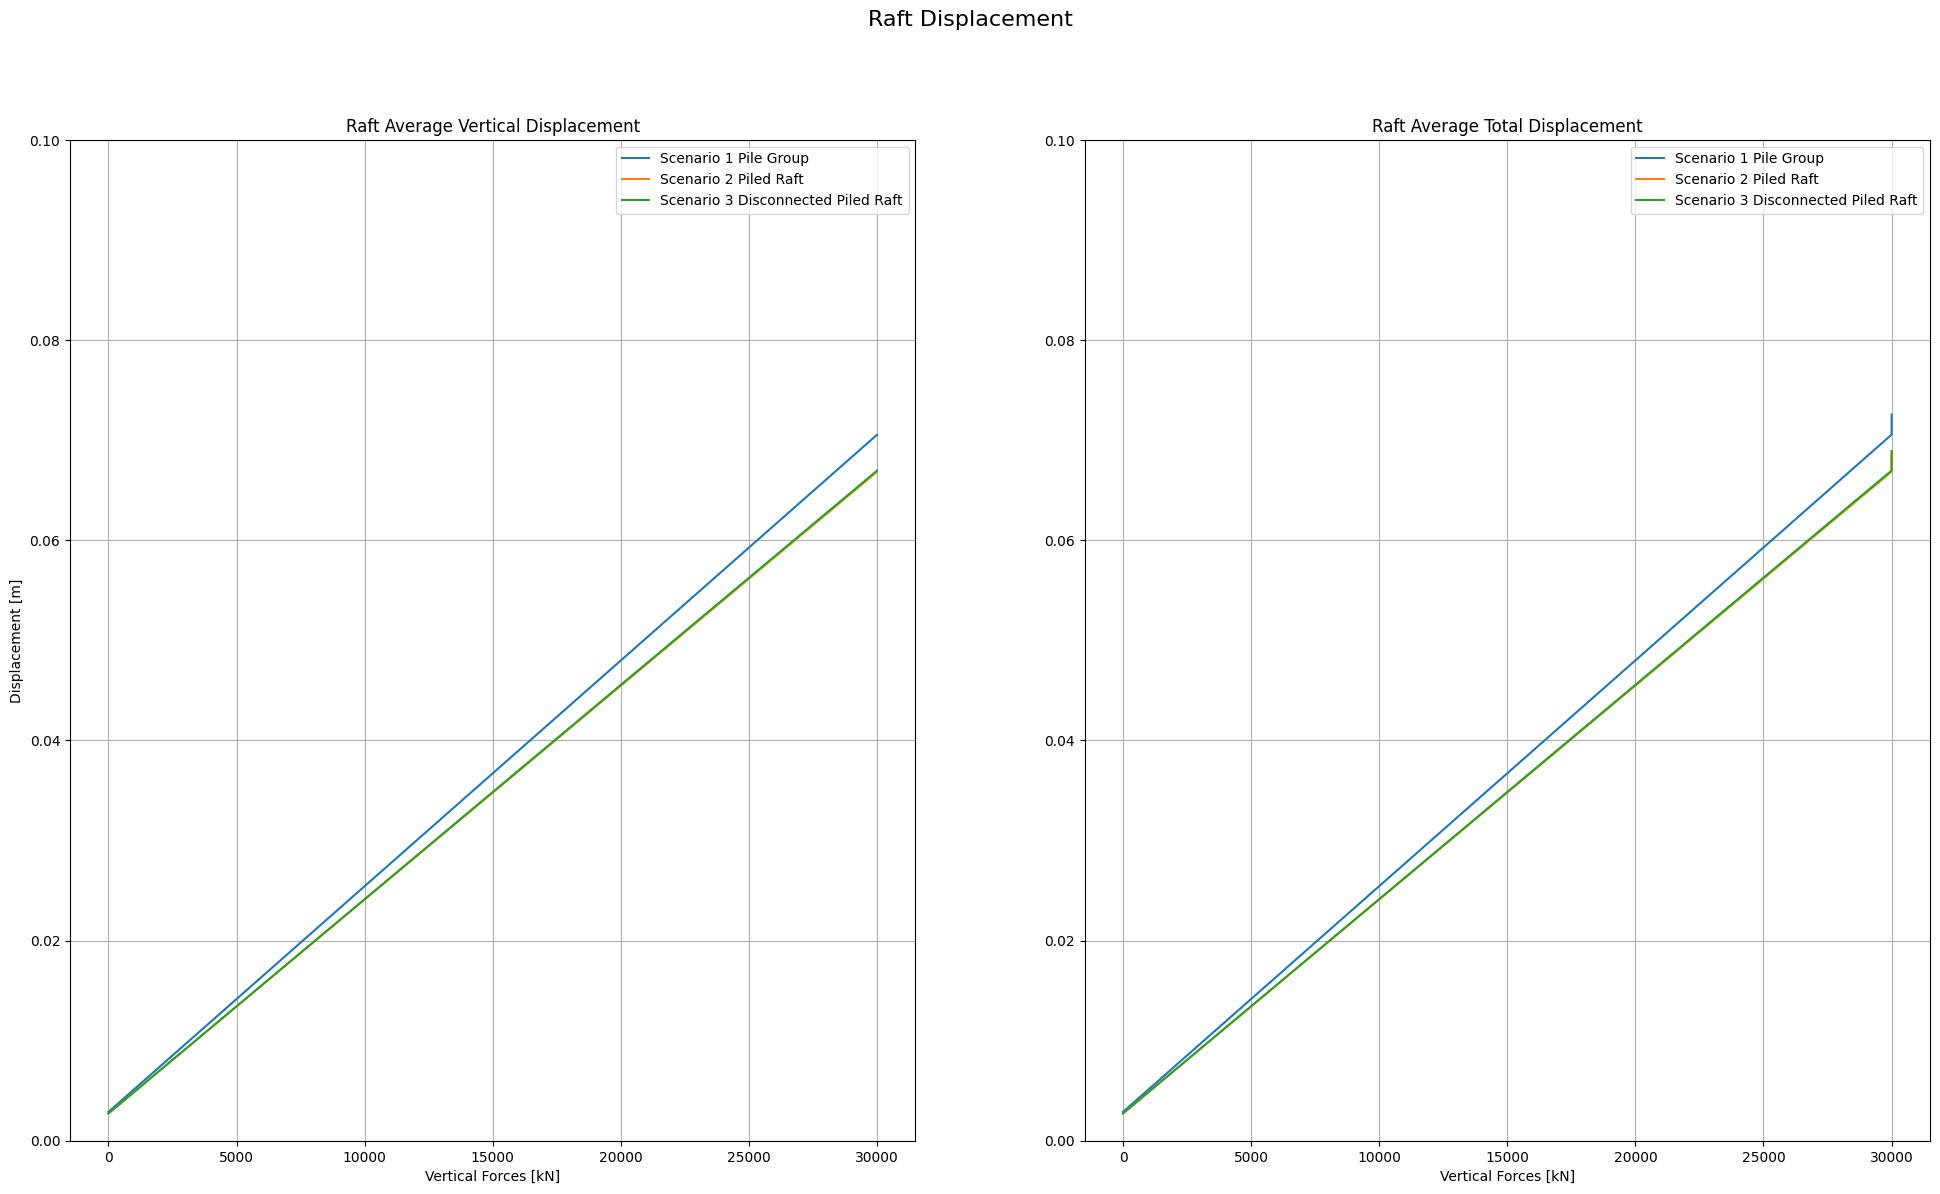

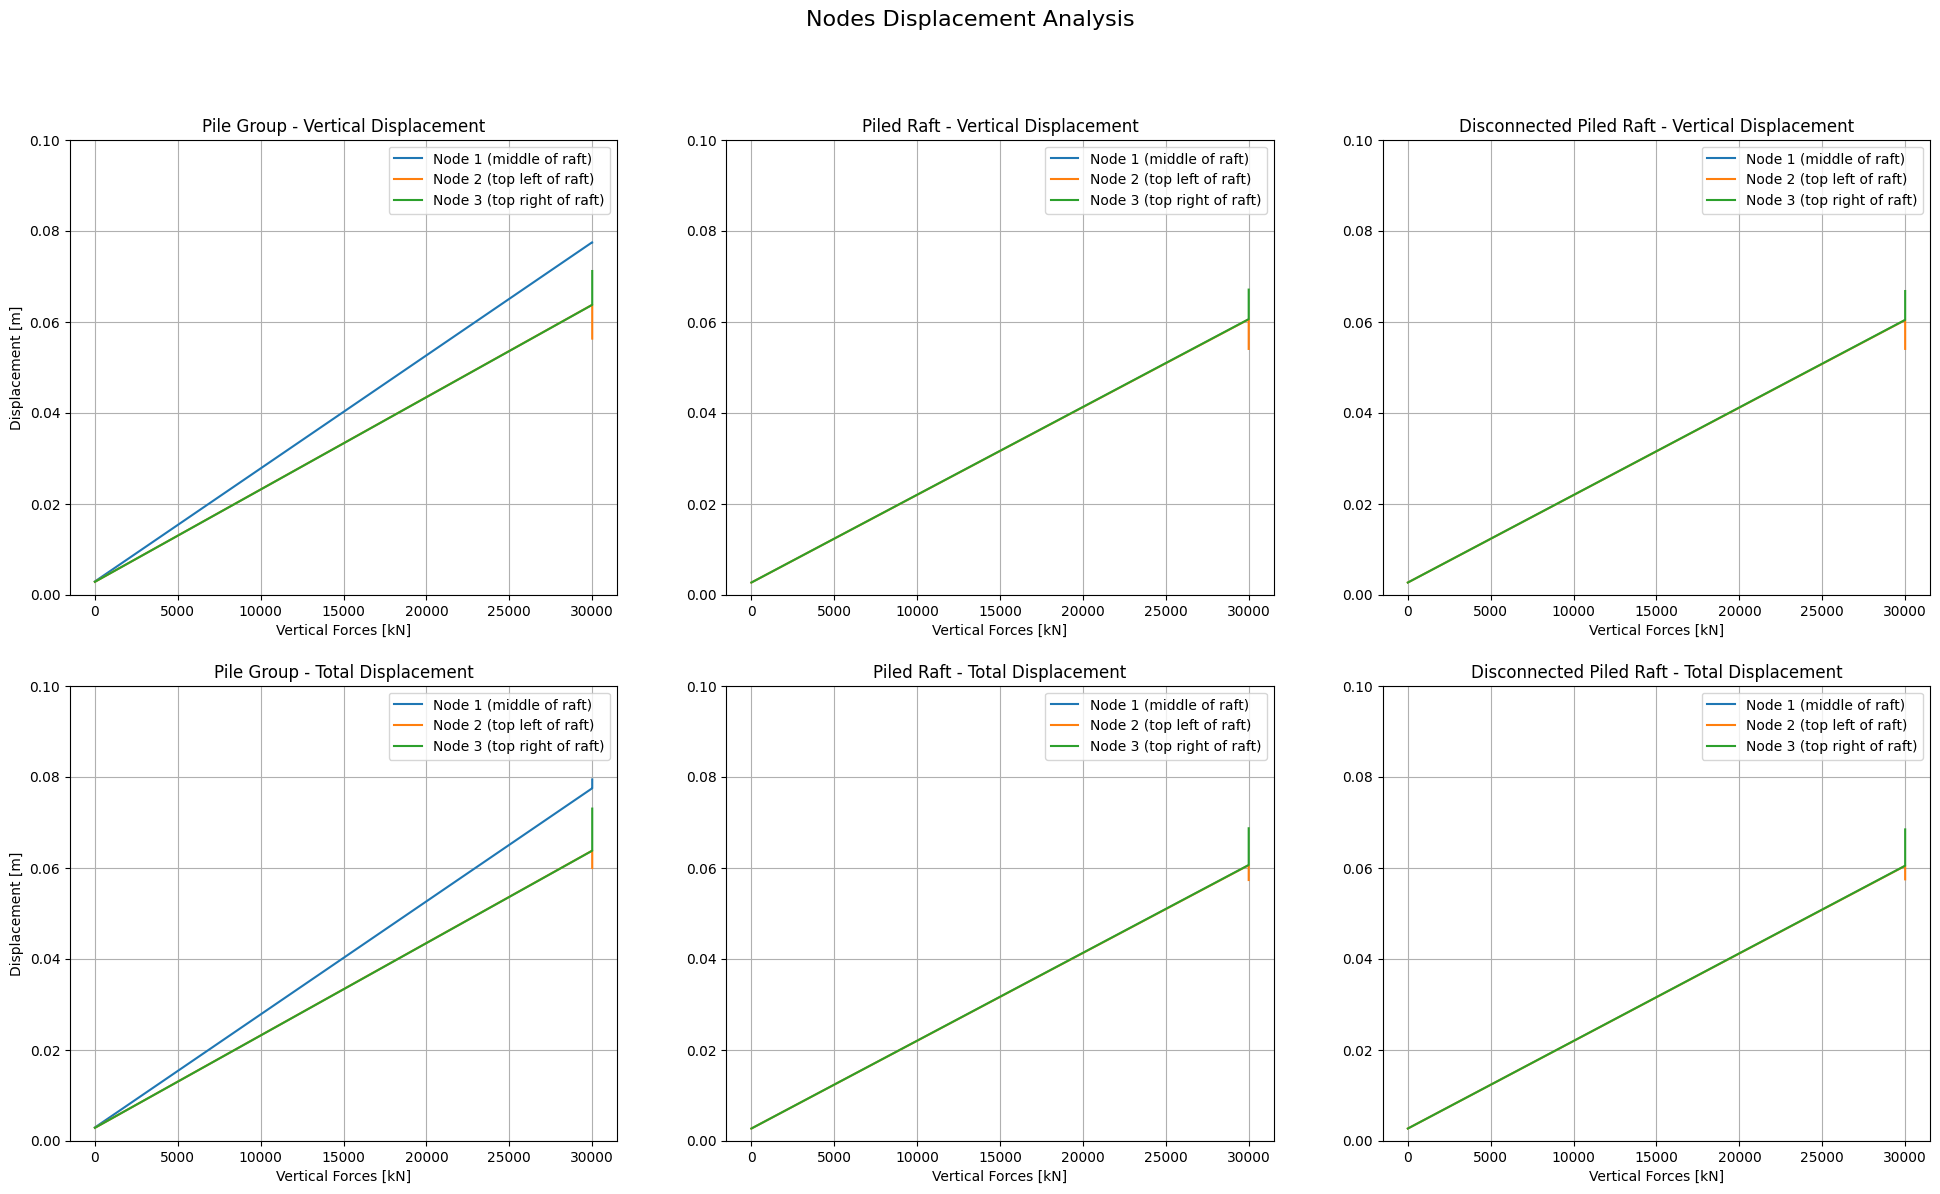

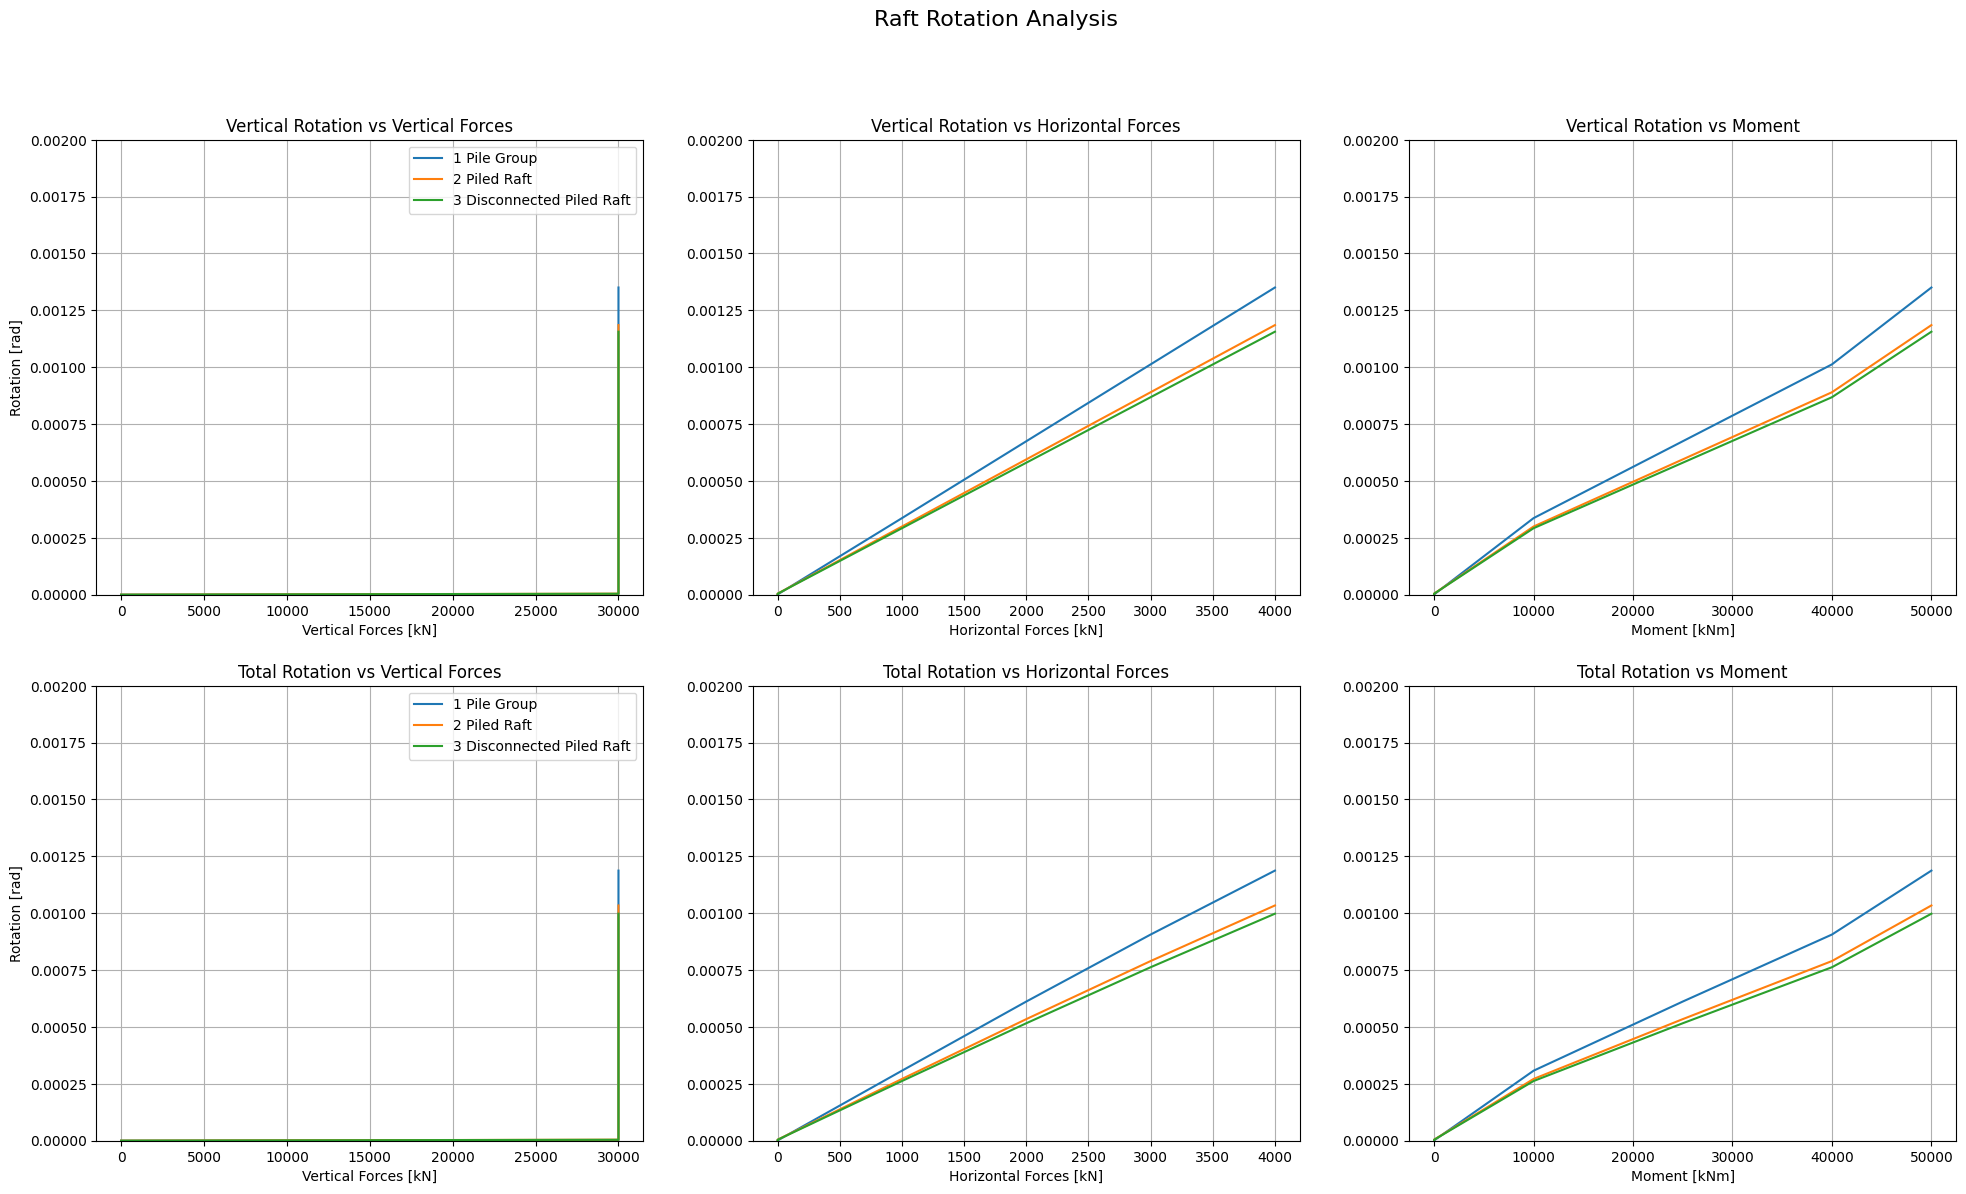

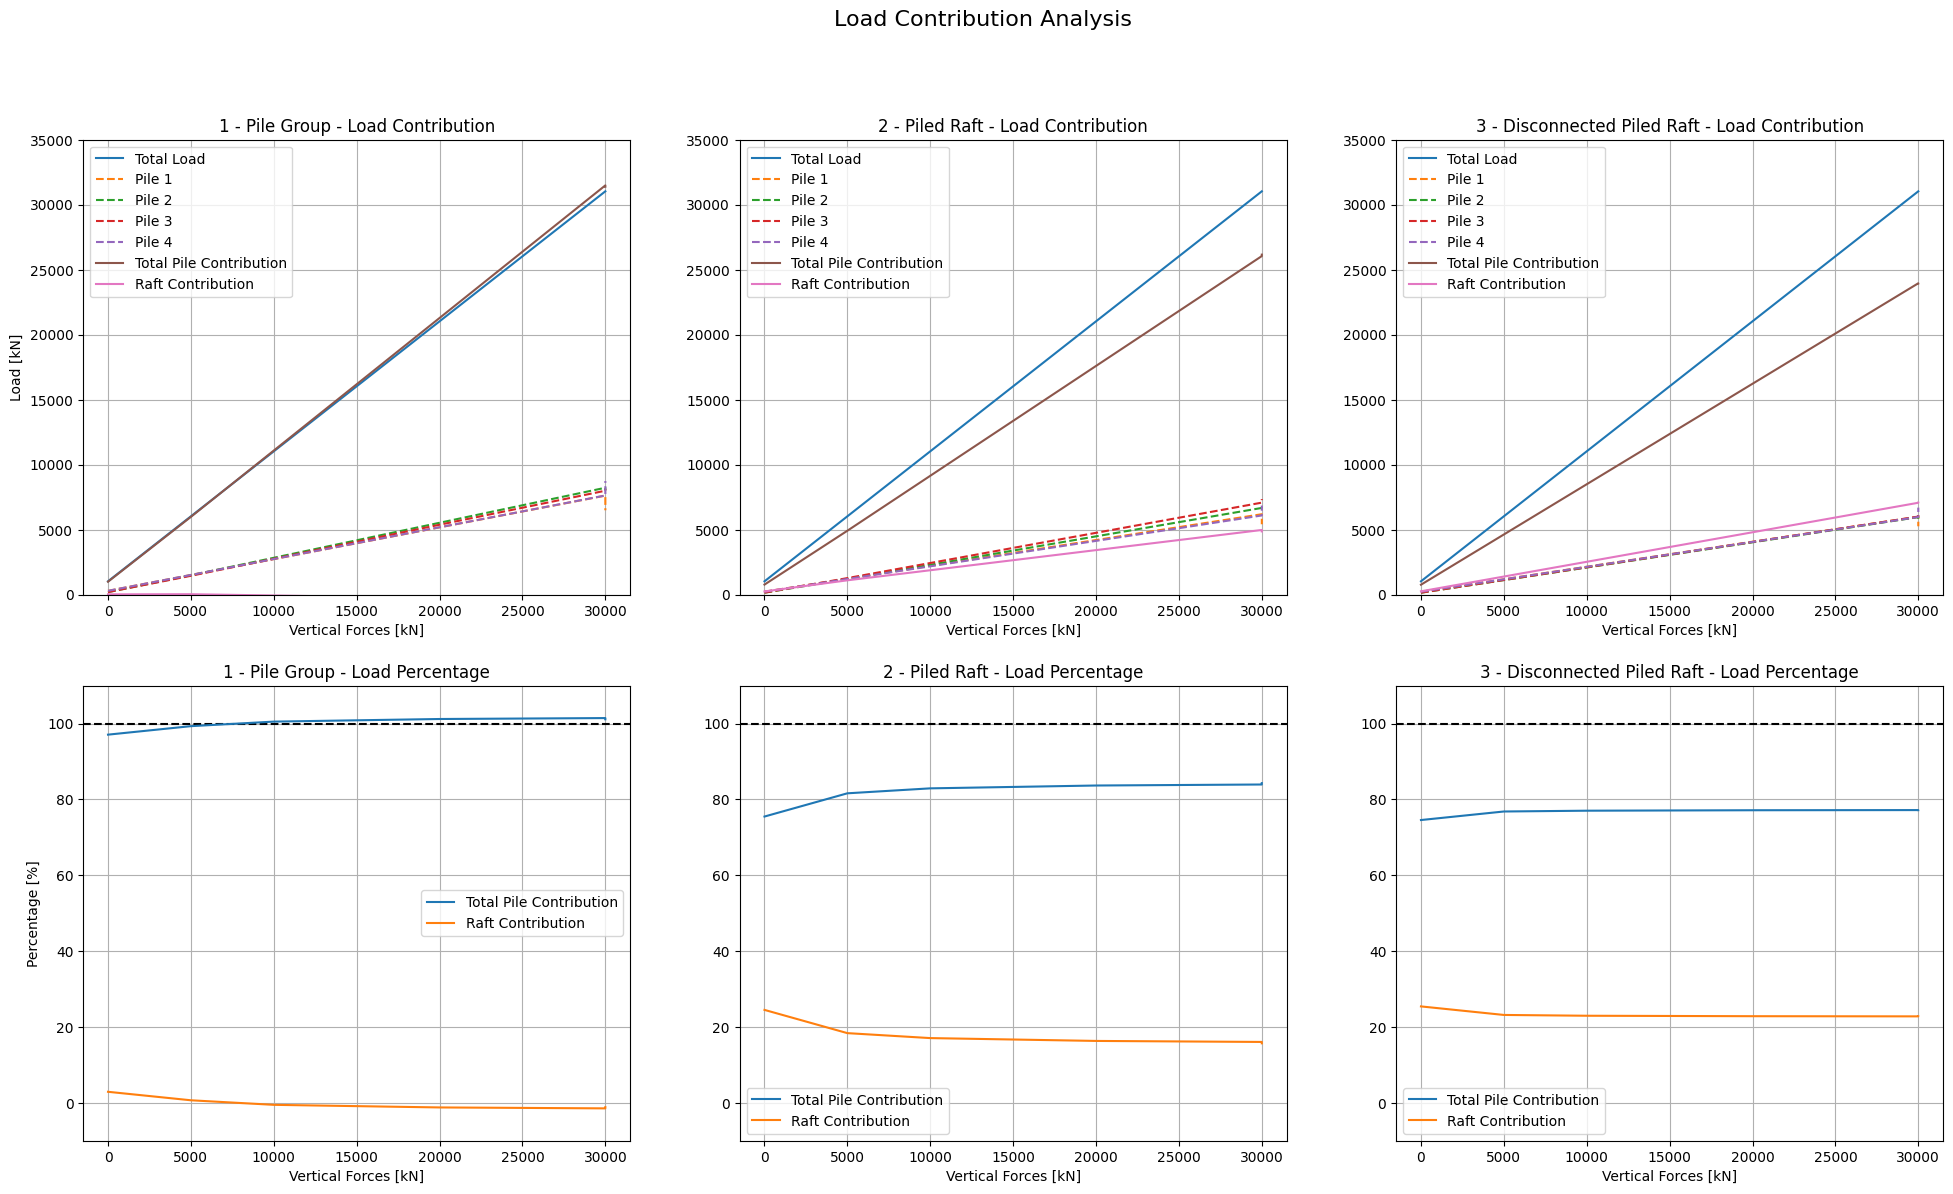

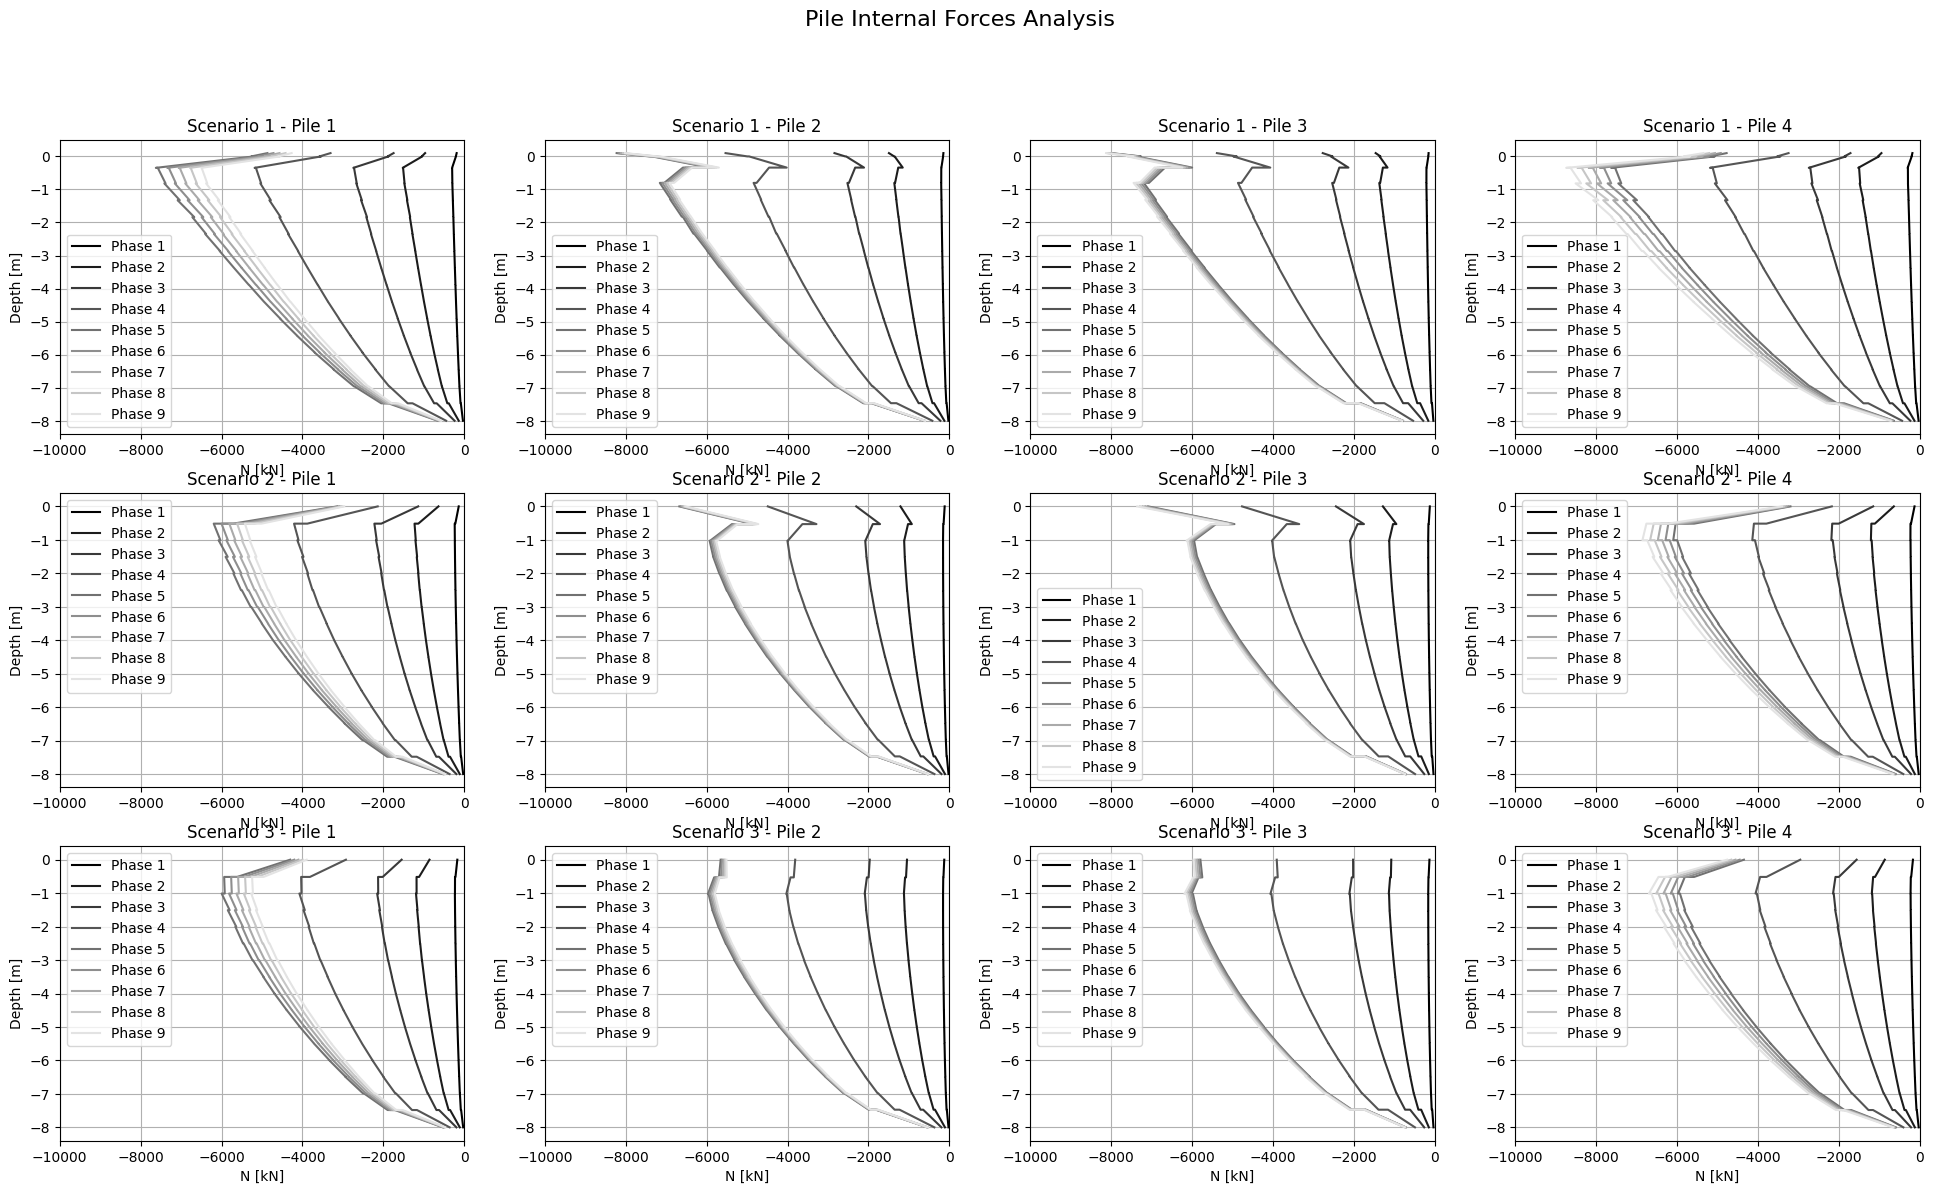

Email sent successfully


'OK'

In [ ]:
for i in scenario_type:
    #define scenario
    scenario = i
    print(f"scenario {i} started")

    #set up and general properties
    new_file()
    general_properties()
    soil_list = list()

    #create material
    create_material_sanisandms()
    create_material_linearelastic()
    create_borehole()
    concrete_material = create_material_concrete()
    beam_material = create_material_dummybeam()

    #structures
    g_i.gotostructures()
    offset = raft_offset()
    draw_raft()
    draw_pile()
    draw_raft_interface()
    draw_dummybeam()
    draw_load()
    create_detail_zone()

    #mesh
    g_i.gotomesh()
    detail_meshing()
    create_mesh()

    #staged construction
    g_i.gotostages()
    initial_phase = stage_initial_phase()
    equilibrium_phase = stage_equilibrium_phase()
    stage_load_phase()

    #solver to pardiso
    solver_to_pardiso()

    #calculate
    g_i.calculate()

    #view output
    g_i.view(g_i.Phases[-1])

    #raft displacement
    raft_data = preprocess_raft_data()

    #nodes displacement
    nodes_data = preprocess_nodes_data()

    #total load
    total_load = calculate_total_load()

    #preprocess pile data
    piles_data = preprocess_pile_data()

    # raft contribution
    raft_data = calculate_raft_contribution()

    #print scenario is finished
    print(f"scenario {i} finished")

#plot after 3 scenarios are finished
plot_raft_displacement()
plot_nodes_displacement()
plot_raft_rotation()
plot_load_contribution()
plot_pile_internal_force()

#send_email()
send_email()

#close the output file
g_o.close()